# Prefix Tuning Full USMLE on Llama 3-8b 

## Setup

In [1]:
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    default_data_collator, 
    get_linear_schedule_with_warmup,
    BitsAndBytesConfig
)
from peft import (
    get_peft_model, 
    PrefixTuningConfig, 
    TaskType
)
from accelerate import dispatch_model, infer_auto_device_map
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import os
import sys

#  GPU Verification
assert torch.cuda.is_available(), "GPU not detected!"
print(f"CUDA version: {torch.version.cuda}")
print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f}GB")
torch.cuda.empty_cache()

# --- 3. Model and Tokenizer Setup ---
model_name = "meta-llama/Meta-Llama-3-8B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # For causal LM padding

# --- Hyperparameters ---
# Adjust hyperparameters for full dataset and larger model
max_length = 512  # Increased for longer sequences
lr = 5e-3  # Slightly lower learning rate for stability
num_epochs = 1  # Reduced epochs for full dataset
batch_size = 1  # Reduced batch size due to larger model
gradient_accumulation_steps = 8  # Accumulate gradients to simulate larger batch
eval_steps = 100  # Evaluate every 500 steps
save_steps = 100  # Save checkpoints every 1000 steps
logging_steps = 50  # Log more frequently
max_grad_norm = 1.0  # Gradient clipping

CUDA version: 12.6
VRAM: 23.57GB


## Load Data

In [3]:
sys.path.append(os.path.abspath(os.path.join('..'))) 
from src.helper_functions import format_mcf_finetuning

# Use full dataset instead of sample
usml_raw = load_dataset("GBaker/MedQA-USMLE-4-options")
usml_train = usml_raw['train']
# Remove the sampling - use full dataset
full_train = usml_train
print(full_train)
print(f"Full dataset size: {len(full_train)}")

Dataset({
    features: ['question', 'answer', 'options', 'meta_info', 'answer_idx', 'metamap_phrases'],
    num_rows: 10178
})
Full dataset size: 10178


In [4]:
# Create train/validation split for monitoring
train_size = int(0.95 * len(full_train))
val_size = len(full_train) - train_size
train_dataset = full_train.select(range(train_size))
val_dataset = full_train.select(range(train_size, train_size + val_size))

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

## Format Data
formatted_train = train_dataset.map(
    format_mcf_finetuning,
    remove_columns=train_dataset.column_names,
    num_proc=4  # Use multiprocessing for faster processing
)

formatted_val = val_dataset.map(
    format_mcf_finetuning,
    remove_columns=val_dataset.column_names,
    num_proc=4
)

Training samples: 9669
Validation samples: 509


## Tokenize Data

In [5]:
def tokenize_function(examples):
    texts = [p + c for p, c in zip(examples['prompt'], examples['completion'])]
    
    tokenized = tokenizer(
        texts,
        truncation=True,
        max_length=max_length,
        padding="max_length",
        return_tensors="pt"
    )
    
    # Create labels (mask prompt tokens)
    prompt_lens = [len(tokenizer(p)['input_ids']) for p in examples['prompt']]
    labels = tokenized["input_ids"].clone()
    for i, plen in enumerate(prompt_lens):
        labels[i, :plen] = -100
    
    tokenized["labels"] = labels
    return tokenized

# Process full dataset with multiprocessing
print("Tokenizing training data...")
tokenized_train = formatted_train.map(
    tokenize_function,
    batched=True,
    remove_columns=['prompt', 'completion'],
    batch_size=16,
    num_proc=4
)

print("Tokenizing validation data...")
tokenized_val = formatted_val.map(
    tokenize_function,
    batched=True,
    remove_columns=['prompt', 'completion'],
    batch_size=16,
    num_proc=4
)

Tokenizing training data...
Tokenizing validation data...


## Prefix Tuning Configuration

In [6]:
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

# Adjust prefix tuning config for Llama 3
peft_config = PrefixTuningConfig(
    peft_type="PREFIX_TUNING",
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    num_virtual_tokens=30,
    prefix_projection=False,             # Keep this if you want projection
    # token_dim=8192,                     # Must match LLaMA 3 8B's hidden size
    # encoder_hidden_size=512,           # This is the intermediate size for projection (can be tuned)
)
    
# Load Llama 3 8b with optimized settings
print("Loading Llama 3 8b model...")
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quant_config,
    device_map="auto",
    torch_dtype=torch.float16,
    token=True,
    trust_remote_code=True,
    use_cache=False,  # Disable cache for training
    # attn_implementation="flash_attention_2" if torch.cuda.is_available() else "eager"
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# # Enable gradient checkpointing for memory efficiency
# model.gradient_checkpointing_enable()

Loading Llama 3 8b model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 1,966,080 || all params: 8,032,227,328 || trainable%: 0.0245


## Training Configuration 

In [7]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

training_args = TrainingArguments(
    output_dir="./llama3-8b-prefix-full-v2",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    learning_rate=lr,
    weight_decay=0.01,
    warmup_steps=100,
    logging_steps=logging_steps,
    eval_steps=eval_steps,
    save_steps=save_steps,
    save_strategy="steps",
    eval_strategy="steps",
    load_best_model_at_end=False,  # Change this to False
    # Remove these lines since we're not loading best model:
    # metric_for_best_model="eval_loss",
    # greater_is_better=False,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=True,
    dataloader_drop_last=True,
    remove_unused_columns=False,
    report_to="none",
    max_grad_norm=max_grad_norm,
    push_to_hub=False,
    # Remove hub settings for now
    # hub_model_id="pippalap/llama3-8b-prefix-full",
    # hub_strategy="checkpoint",
    # Memory optimization
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    # Checkpointing
    save_total_limit=3,  # Keep only 3 checkpoints
    # Remove resume_from_checkpoint for initial run
    # resume_from_checkpoint=True,
    # Fix label names issue
    label_names=["labels"],
)

# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=8  # Optimize for tensor cores
)

# # Optimizer with better settings for larger models
# optimizer = torch.optim.AdamW(
#     model.parameters(), 
#     lr=lr,
#     betas=(0.9, 0.95),  # Better betas for large models
#     eps=1e-8,
#     weight_decay=0.01
# )

# # Learning rate scheduler
# total_steps = len(tokenized_train) // (batch_size * gradient_accumulation_steps) * num_epochs
# lr_scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=100,
#     num_training_steps=total_steps,
# )

## Training

In [9]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,  # Add validation dataset
    data_collator=data_collator,
    # optimizers=(optimizer, lr_scheduler)
)

# trainer.train()

print("Resuming training from checkpoint-1000...")
trainer.train(resume_from_checkpoint="./llama3-8b-prefix-full-v2/checkpoint-1000")

Resuming training from checkpoint-1000...


Step,Training Loss,Validation Loss


TrainOutput(global_step=1208, training_loss=0.27535978058316063, metrics={'train_runtime': 986.9604, 'train_samples_per_second': 9.797, 'train_steps_per_second': 1.225, 'total_flos': 2.229200383597609e+17, 'train_loss': 0.27535978058316063, 'epoch': 0.9994828834419278})

## Plot Training Loss Over Steps 

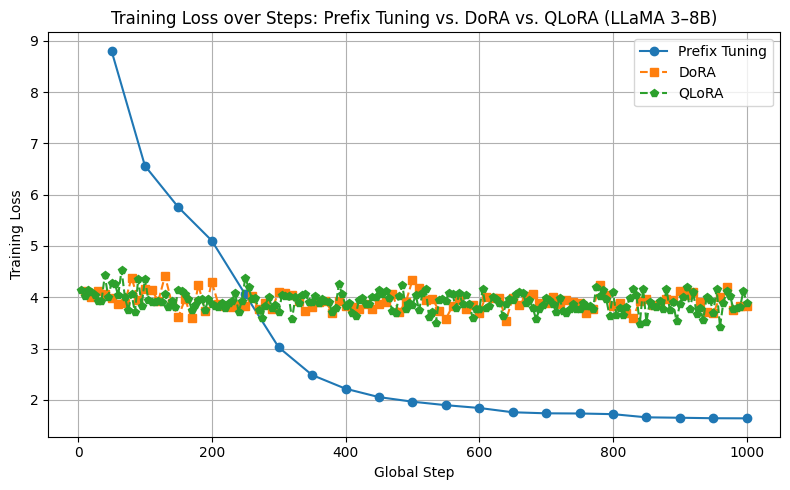

In [20]:
import json
import matplotlib.pyplot as plt

# prefix data
with open("llama3-8b-prefix-full-v2/checkpoint-1000/trainer_state.json", "r") as f:
    prefix_state = json.load(f)

prefix_logs = [entry for entry in prefix_state.get("log_history", []) if "loss" in entry and "step" in entry]
prefix_steps = [entry["step"] for entry in prefix_logs]
prefix_losses = [entry["loss"] for entry in prefix_logs]

# dora data
with open("llama8b-usmle-dora-lowvram/checkpoint-1000/trainer_state.json", "r") as f:
    dora_state = json.load(f)

log_history = dora_state.get("log_history", [])
dora_logs = [entry for entry in log_history if "loss" in entry and "step" in entry]
dora_steps = [entry["step"] for entry in dora_logs]
dora_losses = [entry["loss"] for entry in dora_logs]

# qlora data 
with open("llama8b-usmle-qlora-v2/checkpoint-1000/trainer_state.json", "r") as f:
    qlora_state = json.load(f)

log_history = qlora_state.get("log_history", [])
qlora_logs = [entry for entry in log_history if "loss" in entry and "step" in entry]
qlora_steps = [entry["step"] for entry in qlora_logs]
qlora_losses = [entry["loss"] for entry in qlora_logs]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(prefix_steps, prefix_losses, marker='o', linestyle='-', label='Prefix Tuning')
plt.plot(dora_steps, dora_losses, marker='s', linestyle='--', label='DoRA')
plt.plot(qlora_steps, qlora_losses, marker='p', linestyle='--', label='QLoRA')

plt.title('Training Loss over Steps: Prefix Tuning vs. DoRA vs. QLoRA (LLaMA 3–8B)')
plt.xlabel('Global Step')
plt.ylabel('Training Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Save adapters - to not exclude full model

In [11]:
model.save_pretrained(
    "llama8b-usmle-prefix-tune",
    safe_serialization=True,  # Uses modern .safetensors format
    max_shard_size="200MB"  # Optional: splits large adapters
)

## Upload Model to Hugging Face

In [12]:
!pip install huggingface_hub transformers

In [13]:
from huggingface_hub import login
# Place Login Token
login(token="LOGIN_TOKEN")

In [14]:
# 1. Define your custom model name
MODEL_NAME = "llama8b-usmle-prefix-tune"  
USERNAME = "pippalap"  # Your Hugging Face username

model.push_to_hub("pippalap/llama8b-usmle-prefix-tune")

/opt/conda/lib/python3.10/site-packages/peft/utils/other.py:1221: UserWarning: Unable to fetch remote file due to the following error 403 Client Error. (Request ID: Root=1-68752c70-066969793e3f2a74122c8e90;926ff71c-56cb-4bfd-95bf-608275dc0c3c)

Cannot access gated repo for url https://huggingface.co/meta-llama/Meta-Llama-3-8B/resolve/main/config.json.
Your request to access model meta-llama/Meta-Llama-3-8B has been rejected by the repo's authors. - silently ignoring the lookup for the file config.json in meta-llama/Meta-Llama-3-8B.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:238: UserWarning: Could not find a config file in meta-llama/Meta-Llama-3-8B - will assume that the vocabulary was not modified.
  warnings.warn(


Uploading...:   0%|          | 0.00/7.86M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pippalap/llama8b-usmle-prefix-tune/commit/91ddc2fae385b2f305912b3f0b8174faab3508a7', commit_message='Upload model', commit_description='', oid='91ddc2fae385b2f305912b3f0b8174faab3508a7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pippalap/llama8b-usmle-prefix-tune', endpoint='https://huggingface.co', repo_type='model', repo_id='pippalap/llama8b-usmle-prefix-tune'), pr_revision=None, pr_num=None)

## *Extra* 
## Verifying configurations and checkpoints

In [14]:
## Check checkpoint config

In [15]:
import json
import os

checkpoint_path = "./llama3-8b-prefix-full/checkpoint-1000"

# Check the saved adapter config
config_path = os.path.join(checkpoint_path, "adapter_config.json")
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        saved_config = json.load(f)
    print("Saved PEFT config:")
    print(json.dumps(saved_config, indent=2))
else:
    print("No adapter_config.json found")

# List all files in checkpoint
print("\nFiles in checkpoint:")
print(os.listdir(checkpoint_path))

# Check if there's a saved adapter weights file
adapter_weights_path = os.path.join(checkpoint_path, "adapter_model.bin")
if os.path.exists(adapter_weights_path):
    import torch
    weights = torch.load(adapter_weights_path, map_location='cpu')
    print(f"\nSaved adapter weights keys: {list(weights.keys())}")
    if 'prompt_embeddings' in weights:
        print(f"Prompt embeddings shape: {weights['prompt_embeddings'].shape}")

Saved PEFT config:
{
  "auto_mapping": null,
  "base_model_name_or_path": "meta-llama/Meta-Llama-3-8B",
  "encoder_hidden_size": 1024,
  "inference_mode": true,
  "num_attention_heads": 8,
  "num_layers": 32,
  "num_transformer_submodules": 1,
  "num_virtual_tokens": 30,
  "peft_type": "PREFIX_TUNING",
  "prefix_projection": true,
  "revision": null,
  "task_type": "CAUSAL_LM",
  "token_dim": 1024
}

Files in checkpoint:
['adapter_model.safetensors', '.ipynb_checkpoints', 'optimizer.pt', 'scheduler.pt', 'rng_state.pth', 'training_args.bin', 'adapter_config.json', 'tokenizer.json', 'tokenizer_config.json', 'special_tokens_map.json', 'trainer_state.json', 'README.md']


In [16]:
from safetensors.torch import load_file

adapter_weights = load_file("./llama3-8b-prefix-full/checkpoint-1000/adapter_model.safetensors")

# Show all available keys
print(adapter_weights.keys())


dict_keys(['prompt_embeddings'])


In [17]:
print(adapter_weights['prompt_embeddings'].shape)


torch.Size([30, 65536])
